# Let's build GPT: from scratch, in code, spelled out.

### :/ Andrej Karpathy Lecture::

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy
import re
import unicodedata
import csv

In [2]:
with open('input.txt', 'r', encoding='utf-8') as file:
    txt = file.read()

In [ ]:
print('Len of dataset in chars', len(txt))


Len of dataset in chars 1115394


In [ ]:
print(txt[:200])
print('................')

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you
................


In [3]:
chars = sorted(list(set(txt)))
vocabSiz = len(chars)

print(''.join(chars))
print(vocabSiz)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


### encoder: take a str, output a list of int

### decoder: take a list of int, output a str

In [4]:
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
enc = lambda s: [stoi[c] for c in s]
decod = lambda l: ''.join([itos[i] for i in l])

In [ ]:
print(enc('hii there'))
print(decod(enc('hii thre')))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii thre


### enc entire dataset and store in torch.Tensor

In [5]:
data = torch.tensor(enc(txt), dtype=torch.long)
print(data.shape, data.type)

print(data[:200])

torch.Size([1115394]) <built-in method type of Tensor object at 0x7f518af14590>
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59])


## Split Data
 
 + 90% train, others dev/val 

In [6]:
n = int(0.9*len(data))
trainData = data[:n]
devData = data[n:]


In [7]:
# BlockSize/ ContextLength: max len of the char/token that could feed to trannsformer
blockSiz = 8
trainData[:blockSiz+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

## So the reason why [ y ] have skip sort of: [1:+1]
  
   + is, lets say ''x'' is, ['what is your name']

   + then ''y'' would be ['is your name']:

   *  cos is come after what, the model predicting the next token

++

#### So now if x [18, 47], y would predict [56], Cos its the next token and so forth 

In [9]:
x = trainData[:blockSiz]
y = trainData[1:blockSiz+1]

for token in range(blockSiz):
    contxt = x[:token+1]
    targt = y[token]

    print(f'when input is {contxt}, output is {targt} ')    

when input is tensor([18]), output is 47 
when input is tensor([18, 47]), output is 56 
when input is tensor([18, 47, 56]), output is 57 
when input is tensor([18, 47, 56, 57]), output is 58 
when input is tensor([18, 47, 56, 57, 58]), output is 1 
when input is tensor([18, 47, 56, 57, 58,  1]), output is 15 
when input is tensor([18, 47, 56, 57, 58,  1, 15]), output is 47 
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]), output is 58 


# Batch Dim

 + Batch Size: 
    * how many indepndnt seq will be porcess in parallel
 
 + Block Size:
    * what is the max contxt len for prediction 

In [8]:
torch.manual_seed(1337)
bathSiz = 4
blockSiz = 8

def getBatch(split):
    data = trainData if split == 'train' else devData
    ix = torch.randint(len(data) - blockSiz, (bathSiz, ))
    x = torch.stack([data[i:i+blockSiz] for i in ix])
    y = torch.stack([data[i+1:i+blockSiz+1] for i in ix])

    return x, y

xb, yb = getBatch('train')
print('inputs')
print(xb.shape)
print(xb)

print('targts')
print(yb.shape)
print(yb)

print('\n.....')

for batch in range(bathSiz):
    for tokn in range(blockSiz):
        contxt = xb[batch, :tokn+1]
        targt = yb[batch, tokn]
        print(f'when input is {contxt}, output is {targt}')


inputs
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targts
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])

.....
when input is tensor([24]), output is 43
when input is tensor([24, 43]), output is 58
when input is tensor([24, 43, 58]), output is 5
when input is tensor([24, 43, 58,  5]), output is 57
when input is tensor([24, 43, 58,  5, 57]), output is 1
when input is tensor([24, 43, 58,  5, 57,  1]), output is 46
when input is tensor([24, 43, 58,  5, 57,  1, 46]), output is 43
when input is tensor([24, 43, 58,  5, 57,  1, 46, 43]), output is 39
when input is tensor([44]), output is 53
when input is tensor([44, 53]), output is 56
when input is tensor([44, 53, 56]), output is 1
when input is tensor([44, 53, 5

In [ ]:
# our input to transF
print(xb)

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


# Bigram Language Model,

 
   * ## Embedding:
     + so, emb layer will "plucks out" rows corresponding to token indices in your input.

     + Ex: ['whats your name'], emb will get conrespoding token for this input

In [9]:
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocabSiz):
        super(BigramLanguageModel, self).__init__()
        self.tokenEmbTable = nn.Embedding(vocabSiz, vocabSiz) # 65x65
    
    def forward(self, ix, targt=None):
        #indx and target are both (B, T) tensor or int
        logits = self.tokenEmbTable(ix) # (B, T, C)
        
        if targt is None:
            loss = None
        
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targt = targt.view(B*T)
            loss = F.cross_entropy(logits, targt)

        return logits, loss

    def genarate(self, ix, maxNewTokn):
        #ix is (B,T) array of indeceis in currnt contxt
        
        for i in range(maxNewTokn):
            logits, loss = self(ix)

            # focus only on the last time step
            logits = logits[:, -1, :] #become (B, C)

            probs = F.softmax(logits, dim=1) # (B, C)

            # sample From the Distribution
            ixNext = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sample indx to the running seq 
            ix = torch.cat((ix, ixNext), dim=1) # (B, T+1)
        
        return ix
    
model = BigramLanguageModel(vocabSiz)
logits, loss = model(xb, yb)

print(logits.shape)
print(loss)



torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


In [ ]:
print(decod(model.genarate(ix=torch.zeros((1, 1), dtype=torch.long), maxNewTokn=100)[0].tolist()))
# abviously These Sampling are Garbage, so we would Train


Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


# Train...//

In [10]:
# Create Optimizer
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)


/home/dkcode/miniconda3/envs/tfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
batchSiz = 32

for i in range(10000):
    xb, yb = getBatch('train')

    logits, loss = model(xb, yb)
    optim.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()

print(loss.item())

2.453843355178833


In [ ]:
print(decod(model.genarate(ix=torch.zeros((1, 1), dtype=torch.long), maxNewTokn=100)[0].tolist()))
# Whoo, now we get some Less grabage shit


OTENRBESI RINous O:
Bupouly! ff lathe tat ter jur
ELYoraty,
I sper tornd be ho t helin, t masu kivin


### so the reason why we Predicting garbage is Cos, we 
### Only looking at the last Char

 + so we would make way to Talk These Token to Each other

 + So that it can Predict Well


## This is Where TRANSFORMERS Come to Play


 # __________________________________

# Attention

## - The mathamatical Trick in Self-Attention


  + The **bag-of-words** model is a simple way to represent a document in numerical form before we can feed it into a machine learning algorithm.
 
  + **we, use it to avg all the prev words including current one**

In [15]:
# Consider the Following Exmple

torch.manual_seed(1337)
B, T, C = 4, 8, 2
x = torch.rand(B, T, C)
x.shape

torch.Size([4, 8, 2])

In [14]:
# we want x[b, t] = mean_{i<=t} x[b, i]
xBagOfWord = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xPrev = x[b, :t+1] # {t. C}
        xBagOfWord[b, t] = torch.mean(xPrev, 0)  

### So you see this First Row in tensor is similar:


   +  [0.0783, 0.4956] == [0.0783, 0.4956]
 
   + it's Cos we're avg in one Token,
 
   + But Others Dont the same.. Its cos we Avg Tokens Before it,
 
   + So this Last Row is the Avg of All the Token Before It


## But, This is Very Unefficent:


  + So we can be Very **Efficent** About Doing This Using **Matrix Multiplication**


In [15]:
x[0]

tensor([[0.0783, 0.4956],
        [0.6231, 0.4224],
        [0.2004, 0.0287],
        [0.5851, 0.6967],
        [0.1761, 0.2595],
        [0.7086, 0.5809],
        [0.0574, 0.7669],
        [0.8778, 0.2434]])

In [16]:
xBagOfWord[0]

tensor([[0.0783, 0.4956],
        [0.3507, 0.4590],
        [0.3006, 0.3156],
        [0.3717, 0.4108],
        [0.3326, 0.3806],
        [0.3953, 0.4140],
        [0.3470, 0.4644],
        [0.4134, 0.4368]])

In [18]:
# another Ex:
torch.manual_seed(42)
matA = torch.ones(3, 3)
matB = torch.randint(0, 10, (3, 2)).float()
matC = matA @ matB

print('Matrix A:' )
print(matA)


print('\nMatrix B:' )
print(matB)


print('\nMatrix C:' )
print(matC)

Matrix A:
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

Matrix B:
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])

Matrix C:
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


# Torch.Tril
  + Returns the lower triangular part of the matrix (2-D tensor) or batch of matrices input, the other elements of the result tensor out are set to 0.


In [19]:
torch.tril(torch.ones(3, 3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

# - - - - - - - - - - -
### You can see in this Mat Mul:

   * when a @ b,

           ([[ 2.,  7.],
             [ 8., 11.],
             [14., 16.]])
   
   * if we do mul By by hands, we can see how it /
         
      + The **first row** of a **ignores everything** but the **first row of b**

      + The **second row** includes the **sum of the first two rows of b** 

      + The **third row** **sums** all **three rows of b**



In [24]:
# So now we will adapt this tril thing to out mat
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
b = torch.randint(0, 10, (3,2)).float()
c = a @ b 

print('Matrix A:' )
print(a)

print('\nMatrix B:' )
print(b)

print('\nMatrix C:' )
print(c)

Matrix A:
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

Matrix B:
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])

Matrix C:
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


# - -- - -- - -

### So Now we can see how we can use this .tril thing to Use to get Avg of mat

   + so we can normalize these rows, so that they sum to one,

   + And then we gonna get AVG

   + dim=1 ensures the sum is computed across columns for each row, and keepdim=True keeps the result as a column vector, preserving matrix dimensions for division.


#### Aand Also :
   
   + just like before in tril mat mul:
      
      * we getting first row as it is,

      * 2nd row, we got AVG of the first 2 row 

      * 3rd, we getting AVG Of all the 3 rows 

### How to get Avarage:
   
   + AVG = SUM of the NUM / NUM of Values


In [13]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, dim=1, keepdim=True)
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b 

print('Matrix A:' )
print(a)

print('\nMatrix B:' )
print(b)

print('\nMatrix C:' )
print(c)

Matrix A:
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

Matrix B:
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])

Matrix C:
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


# So By, Manipulating These Elements,  Multiplying Mat, 
  
  + and then mul it with any given mat 

  + we can do this AVG's in this Incremental Fashon 

In [16]:
xBagOfWord = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xPrev = x[b, :t+1] # {t. C}
        xBagOfWord[b, t] = torch.mean(xPrev, 0)  

#  Broadcasting
  
  + During matrix multiplication:
    
    * w (T, T) is applied to each sequence independently.

    * since w, doesn’t have a batch dimension, it’s broadcasted across the batch. 


  +  Thus, w @ x resuls:
    
    * (B, T, T) (broadcasted w for each batch)
    
    * multiplied with:
      + (B T C) seq Tensor

In [ ]:
# Verson 2
w = torch.tril(torch.ones(T, T))
w = w / w.sum(dim=1, keepdim=True)
xBagOfWord2 = w @ x # (B, T, T) @ (B, T, C) ---> (B, T, C)

# so xBagOfWord anc xBagofWord2 are all identical
torch.allclose(xBagOfWord, xBagOfWord2)

True

In [18]:
xBagOfWord[0], xBagOfWord2[0]     

(tensor([[0.0783, 0.4956],
         [0.3507, 0.4590],
         [0.3006, 0.3156],
         [0.3717, 0.4108],
         [0.3326, 0.3806],
         [0.3953, 0.4140],
         [0.3470, 0.4644],
         [0.4134, 0.4368]]),
 tensor([[0.0783, 0.4956],
         [0.3507, 0.4590],
         [0.3006, 0.3156],
         [0.3717, 0.4108],
         [0.3326, 0.3806],
         [0.3953, 0.4140],
         [0.3470, 0.4644],
         [0.4134, 0.4368]]))

In [20]:
# Verson 3

tril = torch.tril(torch.ones(T, T))
w = torch.zeros((T, T))
w = w.masked_fill(tril == 0, float('-inf'))
w = F.softmax(w, dim=1)
xBagOfWord_3 = w @ x 
torch.allclose(xBagOfWord, xBagOfWord_3)

True

In [ ]:
# This is the trill, the tringular shape of 0|1
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
# this is the Weights, w begings with all 0's 
w = torch.zeros((T, T))
w

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

##### So now We use [ maskes_fill ]:
 
   + What, this is doing is,
      
      * for all the element where trill == 0

      * Make them be 'negative infinity' ['-inf']

In [25]:
# So now,, we use [masked_fill ]
w = torch.zeros((T, T))
w = w.masked_fill(tril == 0, float('-inf'))
w

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

# dim ::

  * [ dim=1 ] (row-wise operation): 
    
     + When we apply F.softmax(w, dim=1), it **computes the softmax across each row independently**
  
  * dim=0 (column-wise operation): 
     
     + if  we apply F.softmax(w, dim=0), it **computes the softmax across each column independently.**

In [ ]:
# And then we apply Softmax on dim 1
w = torch.zeros((T, T))
w = w.masked_fill(tril == 0, float('-inf'))
w = F.softmax(w, dim=1)
#and we gonna get exact same mat

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

### And so this Verson 3 or xBagOfWord_3, is also the same way to produce this masked

#### * and the reason why we use this is :
    
   +  **Masking + Softmax** creates a probability distribution over allowed tokens (those the current token can attend to).  

   + The multiplication w @ x applies this distribution, summing over only valid past tokens' contributions.

   + Also These Token will have Connection over each other,, before we only care about past 1 token, [1,2,3] if we 3 we only know 2,, but now, tokens have more connection on 1,2,3 across the all tokens.

   + depending on there values, token gonna find each other intesting to deferint amount 

# Key / Qury / Single Head Perform self-Atten 

In [3]:
torch.manual_seed(1337)
B, T, C = 4, 8, 32
x = torch.randn(B, T, C)

# let's see a single head perform self-Attn
headSiz = 16
key = nn.Linear(C, headSiz, bias=False)
qury = nn.Linear(C, headSiz, bias=False)

k = key(x)  # (B, T, 16)
q = qury(x) # (B, T, 16)

w = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) --> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#w = torch.zeros((T, T)) // Now there not 0's,, now there Come from thse q@k dot product
w = w.masked_fill(tril == 0, float('-inf'))
w = F.softmax(w, dim=-1)
out = w @ x

out.shape

torch.Size([4, 8, 32])

#### Now you can see w/Weights are just not Uniform,
 
  + before its a constant, so it was apllied in the same way to all Batch Element

  + but now, Every single **batch Element** wil have **defferent sort of weights**:

      * Cos, evey single Bath element Contain defferent TOKEN, at Deffent Pos

  + And so this is NOT Data depended   



##### Get Crystal Crear Understanding on Self-Attn, Statquest--> 

In [5]:
w[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

### ALso when we do the Aggrogation / Avg, 
   
   + we dont actualy aggrogate the TKEN exactly

   + We aggrogate, we procude one more Value,

     * Litrly Its called **'VALUE'**

  + IN the same way create Q, K, we gonna create V 

In [7]:
torch.manual_seed(1337)
B, T, C = 4, 8, 32
x = torch.randn(B, T, C)

headSiz = 16
key = nn.Linear(C, headSiz, bias=False)
quary = nn.Linear(C, headSiz, bias=False)
value = nn.Linear(C, headSiz, bias=False)

K = key(x)
Q = quary(x)

w = Q @ K.transpose(-2, -1)

tril = torch.tril(torch.ones(T, T))
w = w.masked_fill(tril == 0, float('-inf'))
w = F.softmax(w, dim=-1)

V = value(x)
out = w @ V

out.shape

torch.Size([4, 8, 16])

In [10]:
w[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

# NOTES : //
   
   + Attention is a  **Communication Mechanism**, can be seen as directed graph looking at each other and 
   aggreating info  with w sum of all nodes that point to them, 

   + There;s no Notion space. Atten simply act over a set of Vec,
        
        * This is why we need **Positional Encoding**

   + Each ex acros the bath dim is procesed Completly indepednt , and never talk to each other 

   + in an Enc atten block, just del the single line that dose masking with tril, Allowing Each Token to Comunicate

   + 'self-atten' mean, that the Keys, Values are produced From the Same Source of Quries

   + ''Scaled'' atten, additional divides W by 1/sqrt(headSiz), 

      * This makes it so When input Q, K are unit Variance, W will be unit var too and Softmax will stay Diffuse and Not Staturated too much



##### READ MORE ON ATTEN /

 # -----------


![Screenshot from 2024-11-20 14-21-44.png](<attachment:Screenshot from 2024-11-20 14-21-44.png>)
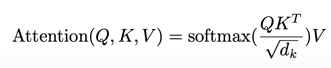

In [8]:
# Reason why devide by the sqrt

k = torch.randn(B, T, headSiz)
q = torch.randn(B, T, headSiz)

w = q @ k.transpose(-2, -1) * headSiz**-0.5 # this  [headSiz**-0.5]==sqrt

In [10]:
k.var()

tensor(1.0449)

In [11]:
q.var()

tensor(1.0700)

In [12]:
w.var()

tensor(1.0918)

 + Softmax uses exponentiation , which **exaggerates differences between input values*.

 + Multiplying the tensor by 8 makes the differences between values even larger before exponentiation.

 + Larger inputs lead to significantly larger exponential values, while smaller inputs become almost negligible.

In [15]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, 0.5]), dim=-1)

tensor([0.2245, 0.1663, 0.2742, 0.3349])

In [17]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, 0.5]) * 8, dim=-1)

tensor([0.0327, 0.0030, 0.1620, 0.8023])

#### So that Scaling [sqrt(d_k)] is to use Control the Varicance, at init

# Layer Norm

 + This will ensure:
   
   * Across the batch dim Any individual Neuron Had **Unit Gaussian Distribution**

   * Mean: Batch Normalization shifts activations to have a mean of 0, centering the distribution.
Standard Deviation 
   
   * (std): It scales activations to have a std of 1, ensuring a consistent spread (unit Gaussian distribution).

#### :So in Batch Normalization, we gonna **Normalize Column**

#### :In Layer Normalization, we gonna **Normalize Rows**


![Screenshot from 2024-11-20 17-57-23.png](<attachment:Screenshot from 2024-11-20 17-57-23.png>)
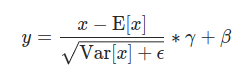

In [10]:
from typing import Any


class LayerNorm:
    def __init__(self, dim, eps=1e-5):
        self.eps = eps

        # para [train with backProp]
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        
        xMean = x.mean(1, keepdim=True) #batch mean
        xVar = x.var(1, keepdim=True) # bath variance

        
        xHat = (x - xMean) / torch.sqrt(xVar + self.eps) # normaliz the Unit Variance

        self.out = self.gamma * xHat + self.beta

        return self.out 
    
    def para(self):
        return [self.gamma, self.beta]


torch.manual_seed(1337)
model = LayerNorm(100)
x = torch.randn(32, 100)
x = model(x)
x.shape

torch.Size([32, 100])

In [11]:
x[:, 0].mean(), x[:, 0].std() # [ mean, std ] of the one feature across the all batch inputs

(tensor(0.1469), tensor(0.8803))

In [12]:
x[0, :].mean(), x[0, :].std() # [ mean, std ] of a single input from batch, of its featurs

(tensor(-9.5367e-09), tensor(1.0000))